In [29]:
import sys; sys.path.append('/home/grads/g/guangzhou92/fftw-3.3.8/FIt-SNE')
from fast_tsne import fast_tsne
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
#sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
ed_data = pd.read_csv('edviz_raw.csv')
y = ed_data[['disposition', 'esi']]
X = ed_data.drop(columns=['disposition', 'esi'])

X_cat = X.select_dtypes(exclude=['int64', 'float64'])
X_dog = X.select_dtypes(include=['int64', 'float64'])


X_cat = pd.get_dummies(X_cat)

X = pd.concat([X_cat, X_dog], axis=1)

X = (X - X.min())/(X.max()-X.min())

X = X.fillna(X.mean())

X_sub = X.sample(100000, random_state = 0)
y_sub = y.sample(100000, random_state = 0)

X_sub.dropna(axis=1, how='all', inplace=True)

In [5]:
########  sparse + t_SNE   ########

In [85]:
#file options: output_file_h100_nonsparse     output_file_5


#df = pd.read_csv('output_file_h100_nonsparse', header=None, sep=' ')
df = pd.read_csv('output_file_5', header=None, sep=' ')



#0:patient id        101: NaN
df = df.drop(columns=[0, 101])

In [86]:
X_trans = fast_tsne(df, perplexity=30, early_exag_coeff=1, 
                    learning_rate=5, late_exag_coeff=-15, seed=42)


#X_trans = fast_tsne(df)

#X_trans = PCA(n_components=3).fit_transform(df)


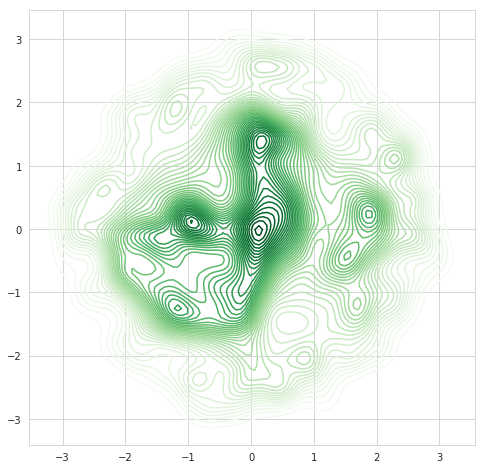

In [87]:
f, ax = plt.subplots(figsize=(8, 8))
sns.kdeplot(X_trans[:,0],X_trans[:,1],cmap='Greens', n_levels=50, shade = False, shade_lowest = False)

In [88]:
df_labels = pd.read_csv('space_separated_labels.csv', header=None, sep=' ')

In [89]:
y1 = pd.get_dummies(df_labels[1]).drop(columns=['Discharge'])

In [90]:
#locations of admit and discharge
#first list is discharge, second list is admit
locs = []
for i in range(0,2): 
    cond = y1 == i
    locs.append(np.where(cond['Admit'].tolist()))

In [91]:
locs

[(array([    1,     2,     3, ..., 99995, 99996, 99998]),),
 (array([    0,     5,     7, ..., 99994, 99997, 99999]),)]

In [92]:
cond = y1 == 0
np.where(cond['Admit'].tolist())

(array([    1,     2,     3, ..., 99995, 99996, 99998]),)

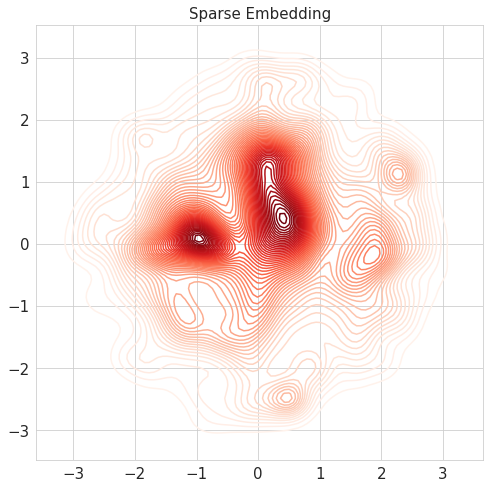

In [109]:
f, ax = plt.subplots(figsize=(8, 8))


#ax = sns.kdeplot(X_trans[locs[0][0],0], X_trans[locs[0][0],1], n_levels=50,
#                 cmap="Blues", shade=False, shade_lowest=False, label='discharged')
#ax = sns.kdeplot(X_trans[locs[1][0],0], X_trans[locs[1][0],1], n_levels=50,
#                 cmap="Reds", shade=False, shade_lowest=False, label='admitted')

ax = sns.kdeplot(X_trans[locs[1][0],0], X_trans[locs[1][0],1], n_levels=50,
                 cmap="Reds", shade=False, shade_lowest=False)

ax.set_title("Sparse Embedding", fontsize=15)
ax.tick_params(labelsize=15)
#ax.legend(fontsize=20)

#ax.xaxis.set_major_locator(plt.MaxNLocator(20))
#ax.yaxis.set_major_locator(plt.MaxNLocator(20))

In [107]:
#get right peak data to csv

right_peak_center = (0.3, 0.6)
right_radius = 0.5

#right_peak = ed_data.ix[X_sub[ (X_trans[:,0]>0)  & (X_trans[:,0]<0.6) & (X_trans[:,1]>0.2) & (X_trans[:,1]<1.4)].index.values]
right_peak = ed_data.ix[X_sub[((X_trans - right_peak_center)**2).sum(axis=1) < right_radius**2].index.values].to_csv('right_peak.csv')
ed_data.ix[X_sub[((X_trans - right_peak_center)**2).sum(axis=1) < right_radius**2].index.values].to_csv('right_peak.csv')



#get left peak data to csv

left_peak_center = (-1, 0.1)
left_radius = 0.5

left_peak = ed_data.ix[X_sub[((X_trans - left_peak_center)**2).sum(axis=1) < left_radius**2].index.values]
ed_data.ix[X_sub[((X_trans - left_peak_center)**2).sum(axis=1) < left_radius**2].index.values].to_csv('left_peak.csv')

/home/grads/g/guangzhou92/enter/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
/home/grads/g/guangzhou92/enter/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/grads/g/guangzhou92/enter/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/grads/g/guangz

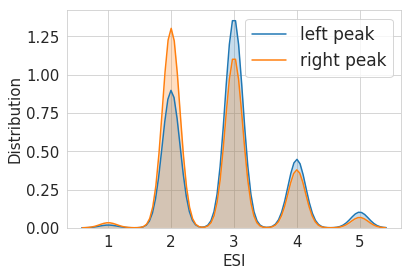

In [102]:
sns.set_style("whitegrid", {'axes.grid' : True})


ax = sns.kdeplot(left_peak['esi'].dropna(), label='left peak', shade=True)
ax = sns.kdeplot(right_peak['esi'].dropna(), label='right peak', shade=True)

ax.set_xlabel('ESI', fontsize=15)
ax.set_ylabel('Distribution', fontsize=15)

ax.tick_params(labelsize=15)
ax.legend(fontsize=17)

In [103]:
def describe_peak(df, df_embedding, peak, radius=0.3, verbose=False):
    
    dim = len(peak)
    df_embedding = df_embedding[:,0:dim]
    
    #ed_data.ix[df[((df_embedding - peak)**2).sum(axis=1) < radius**2].index.values]
    
    peak_entries = df[((df_embedding - peak)**2).sum(axis=1) < radius**2].describe().T
    
    if verbose:
        df_stats = df.describe().T
        print('There are %d samples (%f%%) in this peak.'
              % (peak_entries.iloc[0]['count'],
                 peak_entries.iloc[0]['count']/df_stats.iloc[0]['count'] * 100))
        diff = (peak_entries - df_stats)
        print('This sample is notable for these features above the mean:')
        display(diff['mean'].sort_values(ascending=False).head(10))
        print('This sample is notable for these features below the mean:')
        display(diff['mean'].sort_values(ascending=True).head(10))
    
    else:
        return peak_entries.T

In [104]:
describe_peak(X_sub, X_trans, (-1, 0.1), radius=0.4, verbose=True)

There are 4148 samples (4.148000%) in this peak.
This sample is notable for these features above the mean:


dep_name_B                   0.398932
employstatus_Retired         0.314176
insurance_status_Medicare    0.201139
htn                          0.200612
arrivalmode_ambulance        0.194492
maritalstatus_Widowed        0.179122
previousdispo_Admit          0.173108
age                          0.157025
hyperlipidem                 0.137022
race_White or Caucasian      0.124109
Name: mean, dtype: float64

This sample is notable for these features below the mean:


dep_name_A                     -0.287724
arrivalmode_Car                -0.191133
maritalstatus_Single           -0.178764
insurance_status_Medicaid      -0.160124
employstatus_Not Employed      -0.132631
dep_name_C                     -0.111208
employstatus_Full Time         -0.110310
ethnicity_Hispanic or Latino   -0.097809
previousdispo_Discharge        -0.086715
race_Other                     -0.079945
Name: mean, dtype: float64

In [105]:
describe_peak(X_sub, X_trans, (0.3,0.8), radius=0.3, verbose=True)

There are 2355 samples (2.355000%) in this peak.
This sample is notable for these features above the mean:


race_White or Caucasian      0.381172
employstatus_Retired         0.296792
insurance_status_Medicare    0.237664
hyperlipidem                 0.185442
htn                          0.185075
previousdispo_Admit          0.182331
religion_Catholic            0.178762
age                          0.162825
maritalstatus_Widowed        0.138825
arrivalmode_ambulance        0.133961
Name: mean, dtype: float64

This sample is notable for these features below the mean:


race_Black or African American   -0.253194
maritalstatus_Single             -0.209084
dep_name_B                       -0.188614
insurance_status_Medicaid        -0.179370
employstatus_Not Employed        -0.120498
ethnicity_Hispanic or Latino     -0.117558
race_Other                       -0.107880
previousdispo_Discharge          -0.102200
employstatus_Full Time           -0.094928
arrivalmode_Walk-in              -0.081874
Name: mean, dtype: float64

In [32]:
######## dense + t_sne  ##########

In [75]:
#file options: output_file_h100_nonsparse     output_file_5


df = pd.read_csv('output_file_h100_nonsparse', header=None, sep=' ')
#df = pd.read_csv('output_file_5', header=None, sep=' ')



#0:patient id        101: NaN
df = df.drop(columns=[0, 101])

In [76]:
X_trans = fast_tsne(df, perplexity=30, early_exag_coeff=1, 
                    learning_rate=5, late_exag_coeff=-15, seed=42)


#X_trans = fast_tsne(df)

#X_trans = PCA(n_components=3).fit_transform(df)


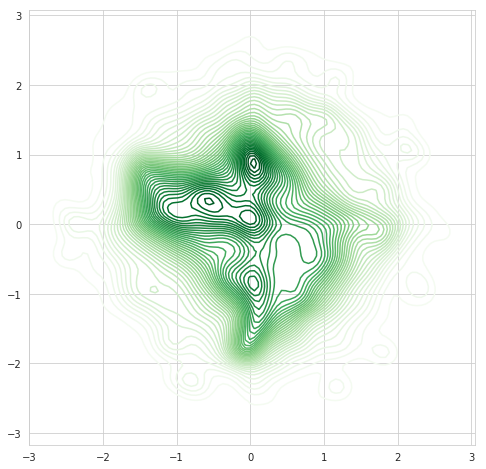

In [77]:
f, ax = plt.subplots(figsize=(8, 8))
sns.kdeplot(X_trans[:,0],X_trans[:,1],cmap='Greens', n_levels=50, shade = False, shade_lowest = False)

In [78]:
df_labels = pd.read_csv('space_separated_labels.csv', header=None, sep=' ')

In [79]:
y1 = pd.get_dummies(df_labels[1]).drop(columns=['Discharge'])

In [80]:
#locations of admit and discharge
#first list is discharge, second list is admit
locs = []
for i in range(0,2): 
    cond = y1 == i
    locs.append(np.where(cond['Admit'].tolist()))

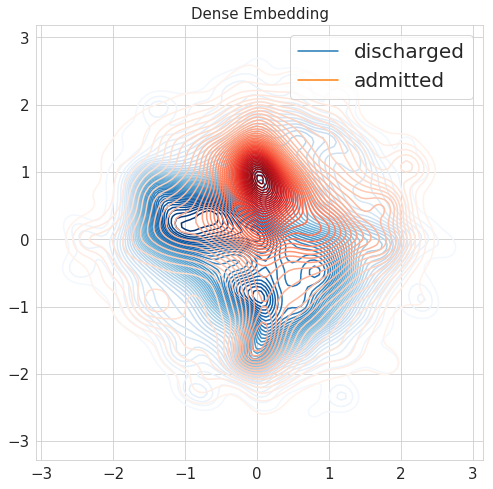

In [81]:
f, ax = plt.subplots(figsize=(8, 8))

ax = sns.kdeplot(X_trans[locs[0][0],0], X_trans[locs[0][0],1], n_levels=50,
                 cmap="Blues", shade=False, shade_lowest=False, label='discharged')
ax = sns.kdeplot(X_trans[locs[1][0],0], X_trans[locs[1][0],1], n_levels=50,
                 cmap="Reds", shade=False, shade_lowest=False, label='admitted')

ax.set_title("Dense Embedding", fontsize=15)
ax.tick_params(labelsize=15)
ax.legend(fontsize=20)


#ax.xaxis.set_major_locator(plt.MaxNLocator(20))
#ax.yaxis.set_major_locator(plt.MaxNLocator(20))

In [82]:
#get peak data to csv

the_peak_center = (0.16, 1.5)
the_radius = 0.2

#the_peak = ed_data.ix[X_sub[ (X_trans[:,0]>0)  & (X_trans[:,0]<0.6) & (X_trans[:,1]>0.2) & (X_trans[:,1]<1.4)].index.values]
the_peak = ed_data.ix[X_sub[((X_trans - the_peak_center)**2).sum(axis=1) < the_radius**2].index.values]
#.to_csv('the_peak.csv')



/home/grads/g/guangzhou92/enter/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


In [83]:
the_peak[the_peak['disposition'] =='Discharge']
#the_peak[the_peak['esi'] == 1].count()

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,...,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
224491,A,4.0,18.0,Female,Hispanic or Latino,Other,English,Catholic,Single,Student - Full Time,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456373,A,3.0,52.0,Female,Non-Hispanic,White or Caucasian,English,Christian,Widowed,Disabled,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
521944,A,3.0,19.0,Male,Hispanic or Latino,Other,English,Catholic,Single,Student - Full Time,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20195,B,3.0,48.0,Male,Non-Hispanic,White or Caucasian,English,Catholic,Single,Disabled,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198258,A,3.0,19.0,Male,Non-Hispanic,White or Caucasian,English,Catholic,Single,Student - Full Time,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79586,A,2.0,73.0,Female,Non-Hispanic,Black or African American,English,Baptist,Widowed,Retired,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254919,A,3.0,56.0,Male,Non-Hispanic,White or Caucasian,English,None,Married,Full Time,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123367,C,4.0,64.0,Female,Hispanic or Latino,White or Caucasian,English,Catholic,Married,Retired,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541582,A,2.0,23.0,Male,Non-Hispanic,White or Caucasian,English,Catholic,Single,Part Time,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
516759,A,2.0,79.0,Male,Non-Hispanic,White or Caucasian,Other,Catholic,Widowed,Retired,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


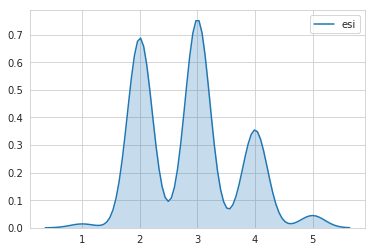

In [84]:
sns.kdeplot(the_peak['esi'].dropna(), shade=True)

In [37]:
######## sparse + PCA  ##########

In [38]:
#file options: output_file_h100_nonsparse     output_file_5


#df = pd.read_csv('output_file_h100_nonsparse', header=None, sep=' ')
df = pd.read_csv('output_file_5', header=None, sep=' ')



#0:patient id        101: NaN
df = df.drop(columns=[0, 101])

In [39]:
#X_trans = fast_tsne(df, perplexity=30, early_exag_coeff=1, 
#                    learning_rate=5, late_exag_coeff=-15, seed=42)


#X_trans = fast_tsne(df)

X_trans = PCA(n_components=3).fit_transform(df)


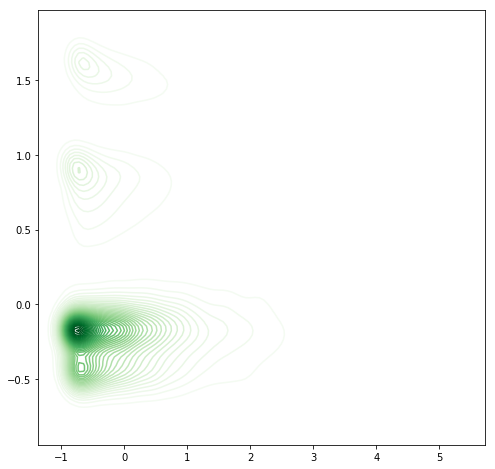

In [40]:
f, ax = plt.subplots(figsize=(8, 8))
sns.kdeplot(X_trans[:,0],X_trans[:,1],cmap='Greens', n_levels=50, shade = False, shade_lowest = False)

In [41]:
df_labels = pd.read_csv('space_separated_labels.csv', header=None, sep=' ')

In [42]:
y1 = pd.get_dummies(df_labels[1]).drop(columns=['Discharge'])

In [43]:
#locations of admit and discharge
#first list is discharge, second list is admit
locs = []
for i in range(0,2): 
    cond = y1 == i
    locs.append(np.where(cond['Admit'].tolist()))

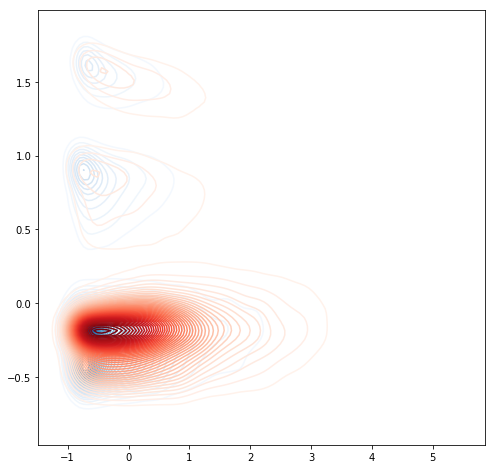

In [44]:
f, ax = plt.subplots(figsize=(8, 8))

ax = sns.kdeplot(X_trans[locs[0][0],0], X_trans[locs[0][0],1], n_levels=50,
                 cmap="Blues", shade=False, shade_lowest=False)
ax = sns.kdeplot(X_trans[locs[1][0],0], X_trans[locs[1][0],1], n_levels=50,
                 cmap="Reds", shade=False, shade_lowest=False)

In [ ]:
######## dense + PCA  ##########

In [ ]:
#file options: output_file_h100_nonsparse     output_file_5


#df = pd.read_csv('output_file_h100_nonsparse', header=None, sep=' ')
df = pd.read_csv('output_file_5', header=None, sep=' ')



#0:patient id        101: NaN
df = df.drop(columns=[0, 101])

In [31]:
#X_trans = fast_tsne(df, perplexity=30, early_exag_coeff=1, 
#                    learning_rate=5, late_exag_coeff=-15, seed=42)


#X_trans = fast_tsne(df)

X_trans = PCA(n_components=3).fit_transform(df)


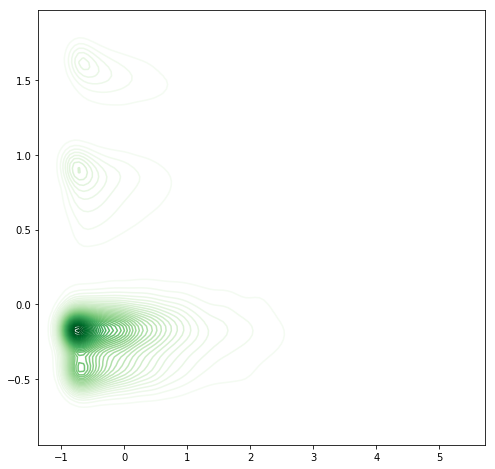

In [32]:
f, ax = plt.subplots(figsize=(8, 8))
sns.kdeplot(X_trans[:,0],X_trans[:,1],cmap='Greens', n_levels=50, shade = False, shade_lowest = False)

In [33]:
df_labels = pd.read_csv('space_separated_labels.csv', header=None, sep=' ')

In [34]:
y1 = pd.get_dummies(df_labels[1]).drop(columns=['Discharge'])

In [35]:
#locations of admit and discharge
#first list is discharge, second list is admit
locs = []
for i in range(0,2): 
    cond = y1 == i
    locs.append(np.where(cond['Admit'].tolist()))

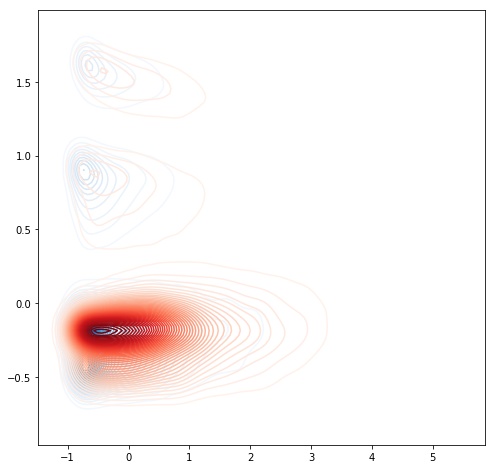

In [36]:
f, ax = plt.subplots(figsize=(8, 8))

ax = sns.kdeplot(X_trans[locs[0][0],0], X_trans[locs[0][0],1], n_levels=50,
                 cmap="Blues", shade=False, shade_lowest=False)
ax = sns.kdeplot(X_trans[locs[1][0],0], X_trans[locs[1][0],1], n_levels=50,
                 cmap="Reds", shade=False, shade_lowest=False)